# data loaders for rollouts 

> This module handles all communication-related functionalities, including message passing, event handling, and notifications.

In [ ]:
#| default_exp data.loaders

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore import *
from fastcore.utils import *

In [ ]:
#| export
from bisect import bisect
from os import listdir
from os.path import join, isdir
from tqdm import tqdm
import torch
import torch.utils.data
import numpy as np


In [ ]:
root = '../marl_grid_data/'
train = True
buffer_size = 10
_files = [join(root, sd) for sd in listdir(root)]
print(len(_files))
if train:
    _files = _files[:-600]
else:
    _files = _files[-600:]

_cum_size = None
_buffer = None
_buffer_fnames = None
_buffer_index = 0
_buffer_size = buffer_size

10355


In [ ]:
_files.__len__()

9755

In [ ]:
_buffer_fnames = _files[_buffer_index:_buffer_index + _buffer_size]
print(len(_buffer_fnames))
print(_buffer_size)
_buffer_index += _buffer_size
print(_buffer_index)
_buffer_index = _buffer_index % len(_files)
print(_buffer_index)
_buffer = []
_cum_size = [0]

10
10
10
10


In [ ]:
for f in _buffer_fnames[0:1]:
    with np.load(f, allow_pickle= True) as data:
        _buffer += [{k: np.copy(v) for k, v in data.items()}]
        # _cum_size += [_cum_size[-1] + _data_per_sequence(data['agent_0_rew'].shape[0])]

In [ ]:
_buffer[0].keys()

dict_keys(['episode_len', 'agent_0_obs', 'agent_0_rew', 'agent_0_act', 'agent_0_info', 'agent_1_obs', 'agent_1_rew', 'agent_1_act', 'agent_1_info'])

In [ ]:
_buffer[0]['episode_len'].item()

1278

In [ ]:
#| export
class _RolloutDataset(torch.utils.data.Dataset): # pylint: disable=too-few-public-methods
    def __init__(self, agent, root, transform, buffer_size=200, train=True, obs_key = 'pov'): # pylint: disable=too-many-arguments
        
        self.agent = agent
        self._transform = transform
        self.obs_key = obs_key
        self._files = [join(root, sd) for sd in listdir(root)]

        def train_test_split(files, train):
            if train:
                return files[:-600]
            else:
                return files[-600:]

        self._files = train_test_split(self._files, train)
        self._cum_size = None
        self._buffer = None
        self._buffer_fnames = None
        self._buffer_index = 0
        self._buffer_size = buffer_size

    # def sample_sequence(self, rollout, agent, seq_len):

    #     episode_len = rollout["episode_len"].item()

    #     # sample start index uniformly in [0, episode_len)
    #     start = np.random.randint(0, episode_len)

    #     # clamp so the sequence fits
    #     start = min(start, episode_len - seq_len)
    #     print(f"Sampling sequence for {agent} from index {start} to {start + seq_len}")

    #     end = start + seq_len
    #     return start, end

    def load_next_buffer(self):
        """ Loads next buffer """
        self._buffer_fnames = self._files[self._buffer_index:self._buffer_index + self._buffer_size]
        self._buffer_index += self._buffer_size
        self._buffer_index = self._buffer_index % len(self._files)
        self._buffer = []
        self._cum_size = [0]

        # progress bar
        pbar = tqdm(total=len(self._buffer_fnames),
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} {postfix}')
        pbar.set_description("Loading file buffer ...")

        for f in self._buffer_fnames:
            with np.load(f, allow_pickle= True) as data:
                self._buffer += [{k: np.copy(v) for k, v in data.items()}] # list of dicts,each dict is an episode data
                self._cum_size += [self._cum_size[-1] + data['episode_len'].item()]
            pbar.update(1)
        pbar.close()

    def __len__(self):
        # to have a full sequence, you need self.seq_len + 1 elements, as
        # you must produce both an seq_len obs and seq_len next_obs sequences
        if not self._cum_size:
            self.load_next_buffer()
        return self._cum_size[-1]

    def __getitem__(self, i):
        # binary search through cum_size
        file_index = bisect(self._cum_size, i) - 1
        seq_index = i - self._cum_size[file_index]
        data = self._buffer[file_index] # list of a dict
        return self._get_data(data, seq_index)

    def _get_data(self, data, seq_index):
        raise NotImplementedError

    def _data_per_sequence(self, data_length):
        raise NotImplementedError

In [ ]:
#| export
class RolloutObservationDataset(_RolloutDataset): # pylint: disable=too-few-public-methods
    """ Encapsulates rollouts.

    Rollouts should be stored in subdirs of the root directory, in the form of npz files,
    each containing a dictionary with the keys:
        - observations: (rollout_len, *obs_shape)
        - actions: (rollout_len, action_size)
        - rewards: (rollout_len,)
        - terminals: (rollout_len,), boolean

     As the dataset is too big to be entirely stored in rams, only chunks of it
     are stored, consisting of a constant number of files (determined by the
     buffer_size parameter).  Once built, buffers must be loaded with the
     load_next_buffer method.

    Data are then provided in the form of images

    :args root: root directory of data sequences
    :args seq_len: number of timesteps extracted from each rollout
    :args transform: transformation of the observations
    :args train: if True, train data, else test
    """
    def _data_per_sequence(self, data_length):
        return data_length

    def _get_data(self, data, seq_index):
        print(f"Getting data at index {seq_index}")
        done = data[f'{self.agent}_info'][seq_index]['done']
        obs = data[f'{self.agent}_obs'][seq_index][self.obs_key].astype(np.uint8)
        return self._transform(obs), done


In [ ]:
# | hide
from torchvision import transforms
import numpy as np

ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
    3, 32, 256, 32, 40

tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((40, 40)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

dataset = RolloutObservationDataset(
    agent='agent_0',
    root='../marl_grid_data/',
    transform=tf,
    buffer_size=10,
    train=True
)
dataset.load_next_buffer()

Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
migs = dataset[10]  # get first item

Getting data at index 10


In [ ]:
migs[1]

False

<matplotlib.image.AxesImage>

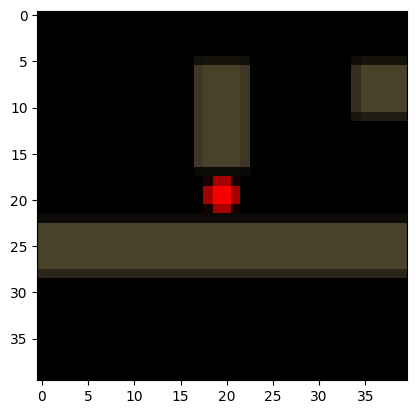

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(migs[0].numpy(), (1, 2, 0)))


In [ ]:
# dataset.load_next_buffer()

Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
# dataset[0][0].shapea

torch.Size([3, 40, 40])

In [ ]:
dataset._cum_size

[0, 1278, 1615, 3488, 7146, 7539, 7633, 7700, 8313, 9169, 9730]

In [ ]:
#| export
class RolloutSequenceDataset(_RolloutDataset): # pylint: disable=too-few-public-methods
    """ Encapsulates rollouts.

    Rollouts should be stored in subdirs of the root directory, in the form of npz files,
    each containing a dictionary with the keys:
        - observations: (rollout_len, *obs_shape)
        - actions: (rovllout_len, action_size)
        - rewards: (rollout_len,)
        - terminals: (rollout_len,), boolean

     As the dataset is too big to be entirely stored in rams, only chunks of it
     are stored, consisting of a constant number of files (determined by the
     buffer_size parameter).  Once built, buffers must be loaded with the
     load_next_buffer method.

    Data are then provided in the form of tuples (obs, action, reward, terminal, next_obs):
    - obs: (seq_len, *obs_shape)
    - actions: (seq_len, action_size)
    - reward: (seq_len,)
    - terminal: (seq_len,) boolean
    - next_obs: (seq_len, *obs_shape)

    NOTE: seq_len < rollout_len in moste use cases

    :args root: root directory of data sequences
    :args seq_len: number of timesteps extracted from each rollout
    :args transform: transformation of the observations
    :args train: if True, train data, else test
    """
    def __init__(self, agent, root, seq_len, transform, buffer_size=200, train=True, obs_key='pov'): # pylint: disable=too-many-arguments
        super().__init__(agent, root, transform, buffer_size, train, obs_key)
        self._seq_len = seq_len
        self.agent = agent

    def _get_agent_data(self, data, seq_index):
        data_dict = {}

        obs_data  = data[f'{self.agent}_obs'][seq_index:seq_index + self._seq_len + 1]
        obs_data  = [self._transform(obs_data[i][self.obs_key].astype(np.uint8)) for i in range(len(obs_data))]
        
        obs, next_obs = obs_data[:-1], obs_data[1:]
        data_dict["obs"] = obs
        data_dict["next_obs"] = next_obs

        action = data[f'{self.agent}_act'][seq_index+1:seq_index + self._seq_len + 1]
        action = action.astype(np.float32)
        data_dict["act"] = action

        data_dict["rew"] = data[f'{self.agent}_rew'][seq_index+1:seq_index + self._seq_len + 1].astype(np.float32)
        
        data_dict["info"] = data[f'{self.agent}_info'][seq_index+1:seq_index + self._seq_len + 1]
        return data_dict

    def _get_data(self, data, seq_index):
        return self._get_agent_data(data, seq_index)

    def _data_per_sequence(self, data_length):
        return data_length - self._seq_len


In [ ]:
from MAWM.data.utils import transform_train, transform_test
from torchvision import transforms
import numpy as np

ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
    3, 32, 256, 32, 40

tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((40, 40)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

dataset = RolloutSequenceDataset(
    agent='agent_0',
    root='../marl_grid_data/',
    seq_len=50,
    transform=tf,
    train=True,
    buffer_size=10
)

In [ ]:
dataset.load_next_buffer()

Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
batch_data = dataset[0]
batch_data.keys()

dict_keys(['obs', 'next_obs', 'act', 'rew', 'info'])

torch.float32


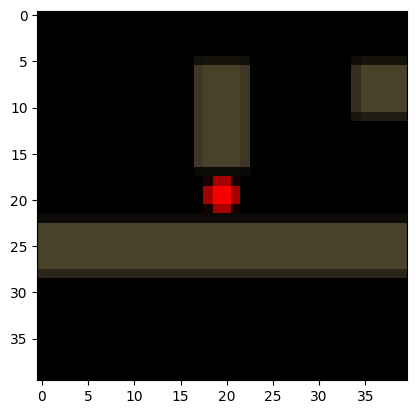

In [ ]:
# # Assuming img1_np is float32 with range [0.0, 255.0]
# import matplotlib.pyplot as plt
# img1 = batch_data['agent_0']['obs'][5]
# print(img1.dtype)
# img1_np = img1.permute(1, 2, 0).numpy()

# # Manually scale the data back to [0.0, 1.0]
# # img_scaled = img1_np / 255.0

# plt.imshow(img1_np) 
# plt.show()

In [ ]:
# batch_data['agent_0']['next_obs'][0]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.7137, 0.7137, 0.7137,  ..., 0.7137, 0.7137, 0.7137],
         [0.7137, 0.7137, 0.7137,  ..., 0.7137, 0.7137, 0.7137],
         [0.7137, 0.7137, 0.7137,  ..., 0.7137, 0.7137, 0.7137]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.7490, 0.7490, 0.7490,  ..., 0.7490, 0.7490, 0.7490],
         [0.7490, 0.7490, 0.7490,  ..., 0.7490, 0.7490, 0.7490],
         [0.7490, 0.7490, 0.7490,  ..., 0.7490, 0.7490, 0.7490]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [ ]:
# len(dataset)

9230

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()